C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipy


Distance between centroids of burst types:
Burst_Type   Non-burst     Other  Parabolic  Square Wave
Burst_Type                                              
Non-burst     0.000000  6.298329   6.489494     9.508167
Other         6.298329  0.000000   4.686298     3.212923
Parabolic     6.489494  4.686298   0.000000     6.379337
Square Wave   9.508167  3.212923   6.379337     0.000000

Overlap threshold (UMAP distance): 3.360

Potentially overlapping burst type pairs:
[('Other', 'Square Wave')]

Number of segments in conflict regions: 148
Burst_Type
Non-burst      13
Other          21
Parabolic      66
Square Wave    48
dtype: int64


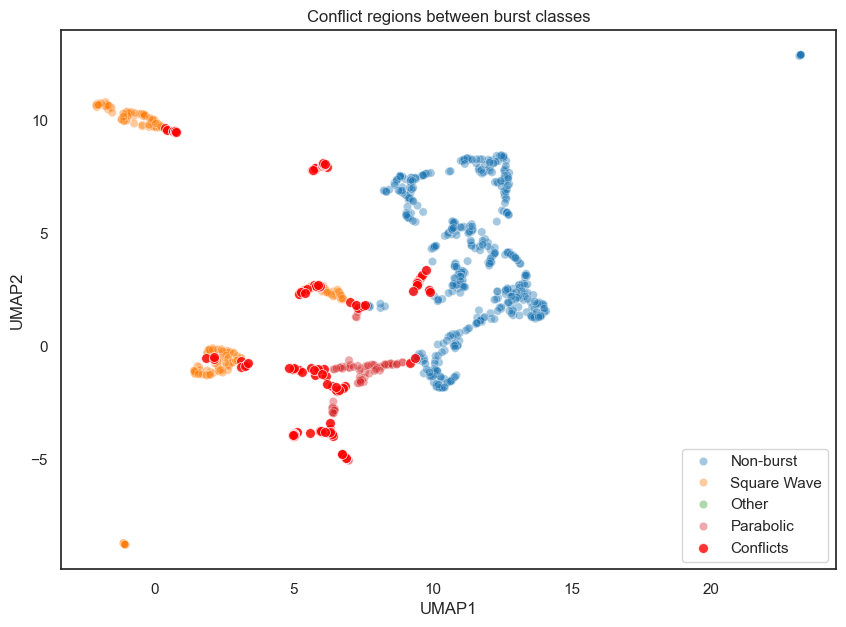

In [4]:
# Libraries
import os                          # For interacting with the operating system (listing files, joining paths)
import pyabf                       # For reading ABF (Axon Binary Format) electrophysiology files
import numpy as np                  # Numerical operations, arrays, linear algebra
import pandas as pd                 # Data manipulation and DataFrame structures
from scipy.stats import skew, kurtosis  # For computing skewness and kurtosis
from scipy.signal import find_peaks, hilbert  # For spike detection and Hilbert transform
from numpy.linalg import lstsq      # Linear least squares fitting
from sklearn.metrics import r2_score    # To evaluate goodness-of-fit
from sklearn.preprocessing import StandardScaler  # Standardize features for UMAP
import umap                         # UMAP for dimensionality reduction

from scipy.spatial import distance  # To compute distances between points or centroids
from sklearn.neighbors import NearestNeighbors  # To find nearest neighbors for conflict detection

import matplotlib.pyplot as plt     # Plotting library
import seaborn as sns               # Statistical data visualization
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})  # Set default Seaborn style

from dash import Dash, dcc, html, Input, Output  # Interactive dashboard components
import plotly.express as px         # Easy plotting for Dash
import plotly.graph_objects as go   # Detailed Plotly graphing
import plotly.io as pio
pio.renderers.default = "browser"   # Open plots in the default browser


# 1. Parameters
folder_path = "bursting"           # Folder containing ABF files
threshold = -35                    # Voltage threshold (mV) to detect spikes
burst_threshold = 0.3              # Maximum inter-spike interval (seconds) for a burst
fs = 10000                         # Sampling frequency in Hz
dt = 1/fs                           # Sampling period (s)
min_spikes_in_burst = 4            # Minimum spikes to define a burst

# Lists to store results across all files and sweeps
all_segment_metrics = []           # Will hold computed metrics for each segment
all_segment_traces = []            # Will store voltage traces of each segment

# List all ABF files in the folder
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]


# 2. ABF Processing
for file_name in abf_files:                     # Loop over each ABF file
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)                  # Load ABF file

    for sweep in range(abf.sweepCount):        # Loop over sweeps in ABF file
        abf.setSweep(sweep)                    # Set the current sweep
        time = abf.sweepX                      # Time array
        voltage = abf.sweepY                   # Voltage array

        
        # Spike detection
        peaks, _ = find_peaks(voltage, height=threshold)  # Find voltage peaks above threshold
        spike_times = peaks / fs                           # Convert peak indices to seconds

        
        # Burst detection
        bursts = []
        if len(spike_times) >= min_spikes_in_burst:
            isi = np.diff(spike_times)                     # Compute inter-spike intervals
            current_burst = [spike_times[0]]              # Initialize first potential burst
            for i in range(1, len(spike_times)):
                if isi[i-1] < burst_threshold:            # ISI below threshold => same burst
                    current_burst.append(spike_times[i])
                else:
                    if len(current_burst) >= min_spikes_in_burst:  # Only save burst if enough spikes
                        bursts.append((current_burst[0], current_burst[-1]))
                    current_burst = [spike_times[i]]      # Start new burst
            # Add last burst if it has enough spikes
            if len(current_burst) >= min_spikes_in_burst:
                bursts.append((current_burst[0], current_burst[-1]))


        # Segment creation (burst vs non-burst)
        segments = []
        for start, end in bursts:                         # Add burst segments
            segments.append((start, end, "Burst"))
        if bursts:
            # Add non-burst segments before first burst
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            # Add non-burst segments between bursts
            for i in range(len(bursts)-1):
                segments.append((bursts[i][1], bursts[i+1][0], "Non-burst"))
            # Add non-burst segment after last burst
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            # No bursts detected: whole sweep is non-burst
            segments.append((time[0], time[-1], "Non-burst"))

        
        # Burst classification
        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):
            if seg_type == "Burst":
                # Extract voltage segment
                seg_mask = (time >= seg_start) & (time <= seg_end)
                seg_voltage = voltage[seg_mask]

                # Estimate mean voltage of neighboring non-burst segments
                prev_mean = np.nan
                next_mean = np.nan
                if i > 0:
                    prev_end = segments[i-1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments)-1:
                    next_start = segments[i+1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])
                inter_mean = np.nanmean([prev_mean, next_mean])  # Mean of neighboring regions

                # Minimum voltage inside the burst
                burst_min = np.min(seg_voltage)

                # Fit a 2nd-degree polynomial (parabola) to the burst for shape assessment
                t_fit = np.linspace(-0.5, 0.5, len(seg_voltage))
                X = np.vstack([t_fit**2, t_fit, np.ones_like(t_fit)]).T
                coef, *_ = lstsq(X, seg_voltage, rcond=None)
                y_hat = X @ coef
                r2_parabola = r2_score(seg_voltage, y_hat)  # Goodness of fit

                # Compute symmetry using Hilbert envelope
                analytic_signal = hilbert(seg_voltage)
                envelope = np.abs(analytic_signal)
                half = len(envelope)//2
                symmetry = (np.corrcoef(envelope[:half], envelope[-half:][::-1])[0,1]
                            if half>=2 else np.nan)

                # Spike rate inside the burst
                seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
                spike_rate = len(seg_peaks)/(seg_end - seg_start)

                # Classify burst type based on min voltage vs neighboring mean
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                # Non-burst segments
                burst_type = "Non-burst"

            burst_types.append(burst_type)


        # Segment metrics computation
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]

            duration = seg_end - seg_start        # Segment duration
            burst_type = burst_types[j]           # Already classified burst type

            # Recalculate peaks and ISI
            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)
            mean_isi = np.mean(np.diff(seg_peaks/fs)) if num_peaks>=2 else 0

            # Basic statistics
            if len(seg_voltage)<2:
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
            else:
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                area_val = np.trapezoid(seg_voltage, dx=dt)  # Area under curve

            # Derivative-based statistics
            if len(seg_voltage)<2:
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                deriv = np.diff(seg_voltage)/dt
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)

            # Save metrics and voltage traces
            all_segment_metrics.append([
                file_name, sweep, seg_type, burst_type, duration,
                num_peaks, mean_isi,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])
            all_segment_traces.append(seg_voltage.tolist())


# 3. Save CSV and voltage traces
df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration",
    "Num_Peaks", "Mean_ISI",
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv", "Skewness_Deriv", "Kurt_Deriv"
])
df_segments.to_csv("segment_voltage_metrics_with_ISI_and_peaks.csv", index=False)
np.save("segment_traces.npy", np.array(all_segment_traces, dtype=object))


# 4. UMAP dimensionality reduction
header = list(df_segments)[4:]              # Features used for UMAP
X = np.array(df_segments[header])
y = np.array(df_segments.Burst_Type)

# Standardize data and fit UMAP
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Combine UMAP embedding with metadata
df_umap = pd.DataFrame(embedding, columns=["UMAP1","UMAP2"])
df_umap["Burst_Type"] = y
df_umap["id"] = np.arange(len(df_umap))


# 4b. Burst type conflicts detection
df_umap["Index"] = df_segments.index

# Compute centroids of each burst type
centroids = df_umap.groupby("Burst_Type")[["UMAP1","UMAP2"]].mean()
dist_matrix = distance.cdist(centroids.values, centroids.values)  # Pairwise distances
dist_df = pd.DataFrame(dist_matrix, index=centroids.index, columns=centroids.index)
print("\nDistance between centroids of burst types:")
print(dist_df)

# Compute threshold to detect potential overlaps
threshold = np.percentile(dist_matrix[dist_matrix>0], 10)
print(f"\nOverlap threshold (UMAP distance): {threshold:.3f}")

# Identify pairs of burst types that are too close
close_pairs = []
for i, type_i in enumerate(centroids.index):
    for j, type_j in enumerate(centroids.index):
        if j>i and dist_matrix[i,j]<threshold:
            close_pairs.append((type_i,type_j))
print("\nPotentially overlapping burst type pairs:")
print(close_pairs)


# Conflict points detection using nearest neighbors
X_umap = df_umap[["UMAP1","UMAP2"]].values
labels = df_umap["Burst_Type"].values
nbrs = NearestNeighbors(n_neighbors=8).fit(X_umap)
distances, indices = nbrs.kneighbors(X_umap)

conflict_indices = []
for i, neighbors in enumerate(indices):
    own_type = labels[i]
    neighbor_types = labels[neighbors]
    if np.any(neighbor_types != own_type):  # If neighbors have different type, mark as conflict
        conflict_indices.append(df_umap.iloc[i]["Index"])

# Extract conflicting segments
conflicts_df = df_segments.iloc[conflict_indices]
print(f"\nNumber of segments in conflict regions: {len(conflicts_df)}")
print(conflicts_df.groupby("Burst_Type").size())

# Visualize conflict regions in UMAP
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="Burst_Type", alpha=0.4, palette="tab10")
sns.scatterplot(data=df_umap.iloc[conflict_indices], x="UMAP1", y="UMAP2", color="red", s=50, label="Conflicts", alpha=0.8)
plt.legend()
plt.title("Conflict regions between burst classes")
plt.show()


# 5. Interactive Dash dashboard
app = Dash(__name__)
app.layout = html.Div([
    html.H2("Interactive Explorer: UMAP + Bursts"),
    html.P("Click a point to visualize its corresponding voltage trace."),

    # UMAP scatter plot
    dcc.Graph(
        id="umap",
        figure=px.scatter(
            df_umap,
            x="UMAP1",
            y="UMAP2",
            color="Burst_Type",
            hover_data=["id","Burst_Type"],
            custom_data=["id"],
            title="UMAP of segments"
        )
    ),

    # Voltage trace viewer
    dcc.Graph(id="timeseries")
])

# Callback function: update voltage trace plot when UMAP point clicked
@app.callback(
    Output("timeseries","figure"),
    Input("umap","clickData")
)
def display_timeseries(clickData):
    if clickData is None:
        fig = go.Figure()
        fig.update_layout(title="Click a point to view its burst trace")
        return fig

    burst_id = clickData["points"][0]["customdata"][0]  # Get selected segment ID
    y = np.array(all_segment_traces[int(burst_id)])     # Extract voltage trace
    t = np.linspace(0, len(y)/fs, len(y))              # Time axis

    # Plot selected segment
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=t, y=y, mode="lines", name=f"Segment {burst_id}"))
    fig.update_layout(
        title=f"Time series of segment {burst_id}",
        xaxis_title="Time (s)",
        yaxis_title="Voltage (mV)"
    )
    return fig

# Run the interactive dashboard
if __name__ == "__main__":
    app.run(debug=True)

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\1294292946.py:136: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\1294292946.py:136: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\1294292946.py:136: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\1294292946.py:136: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\1294292946.py:136: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\1294292946.py:136: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\1294292946.py:136: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\1294292946.py:136: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\1294292946.py:136: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipy

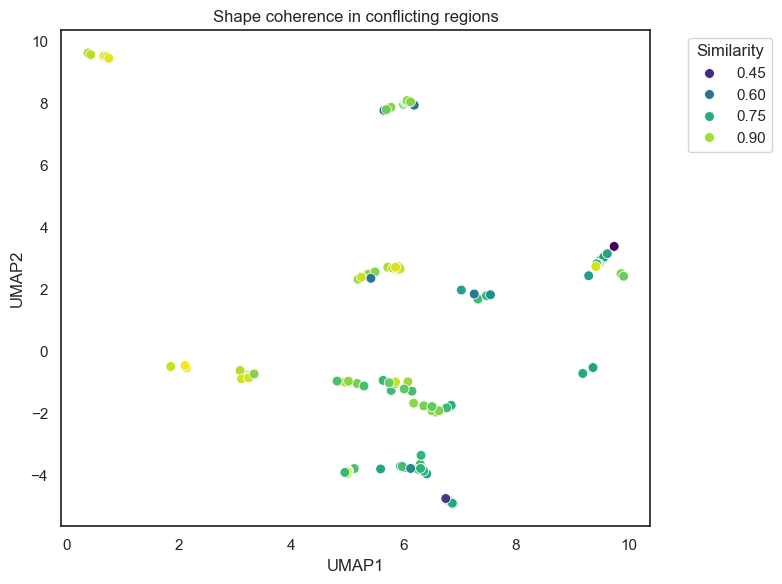

Low-similarity conflicting bursts (<p10): 15


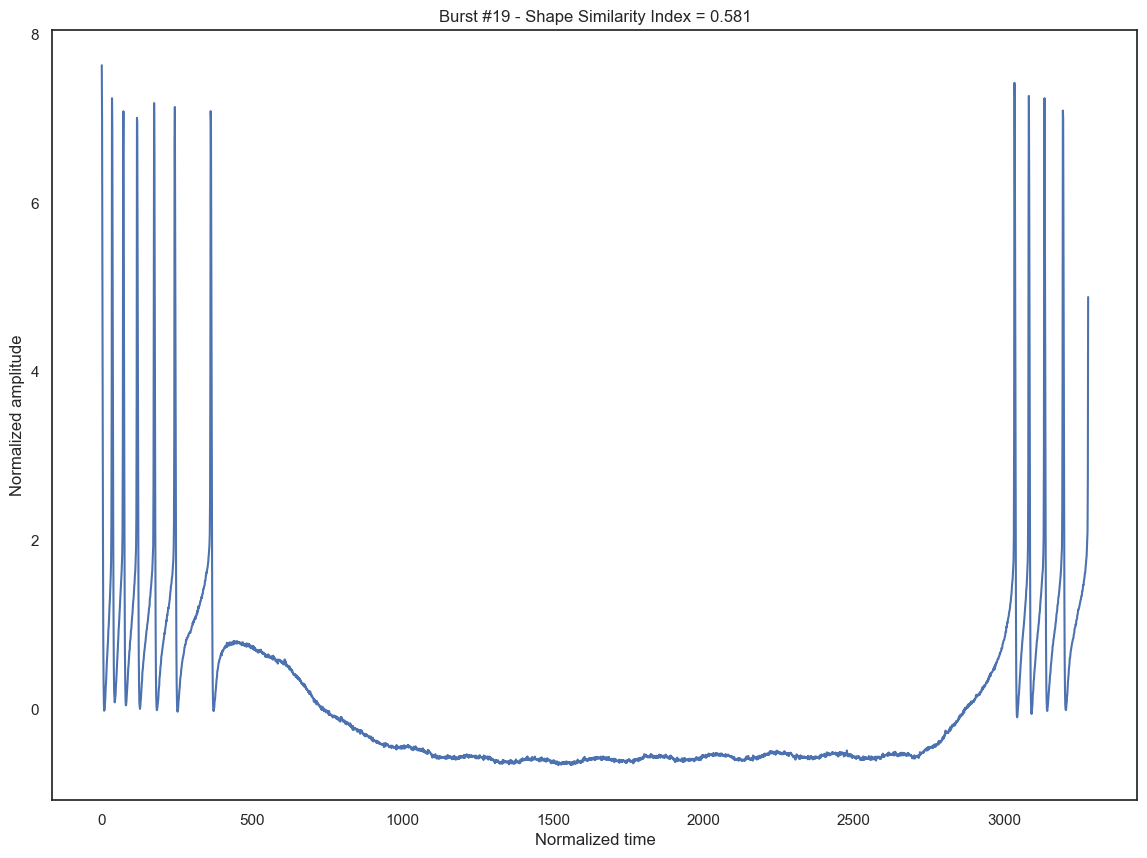

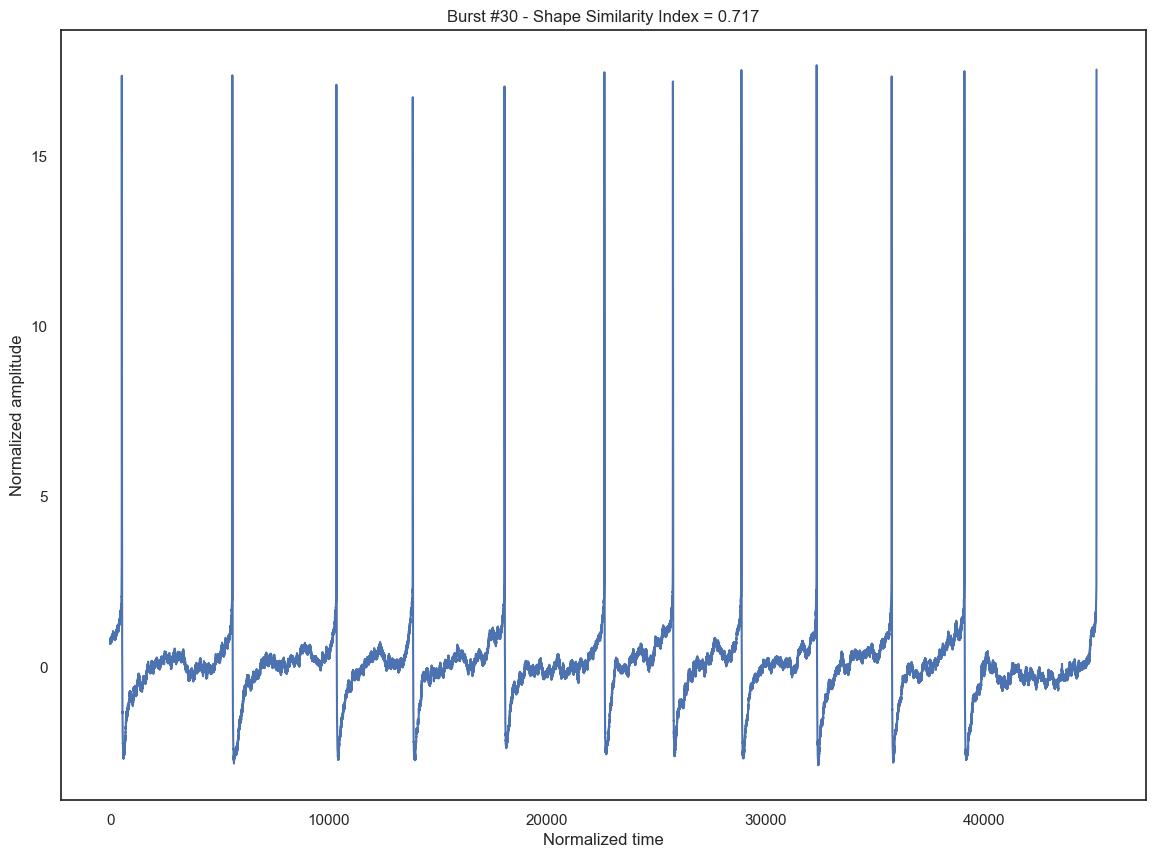

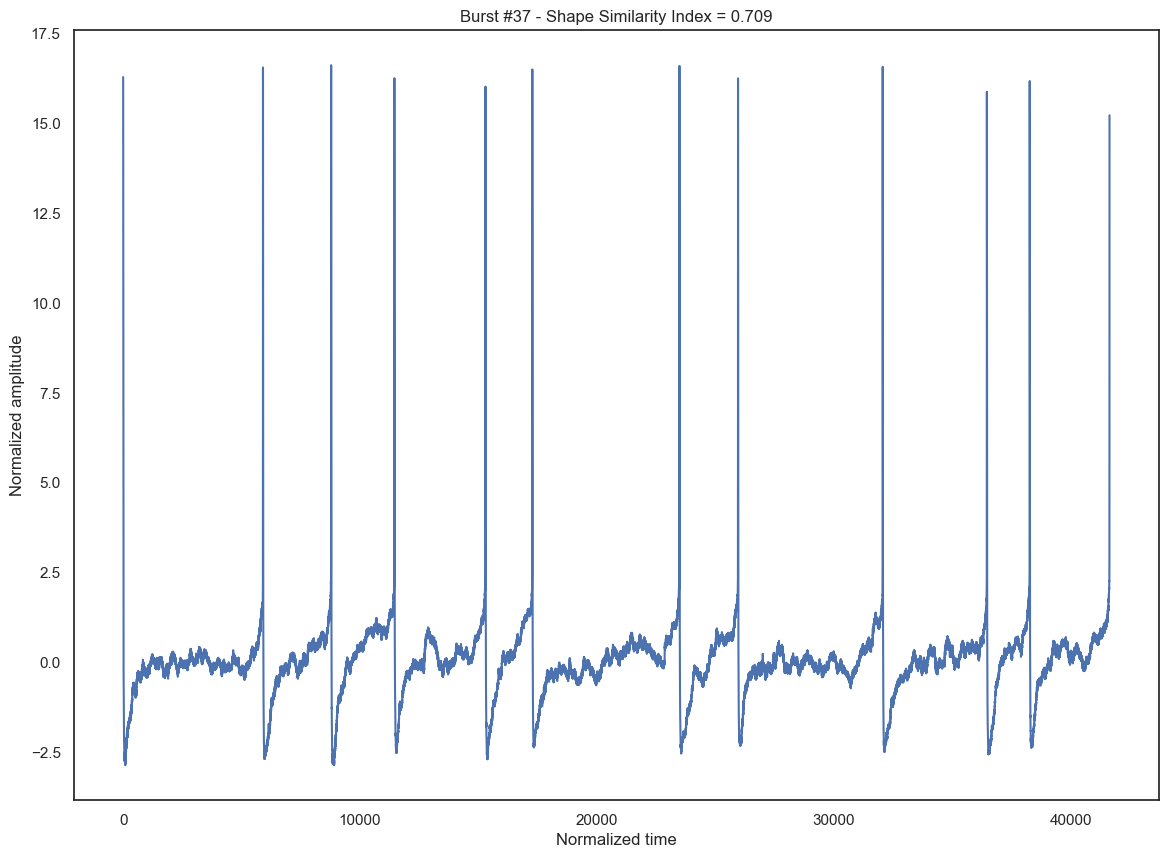

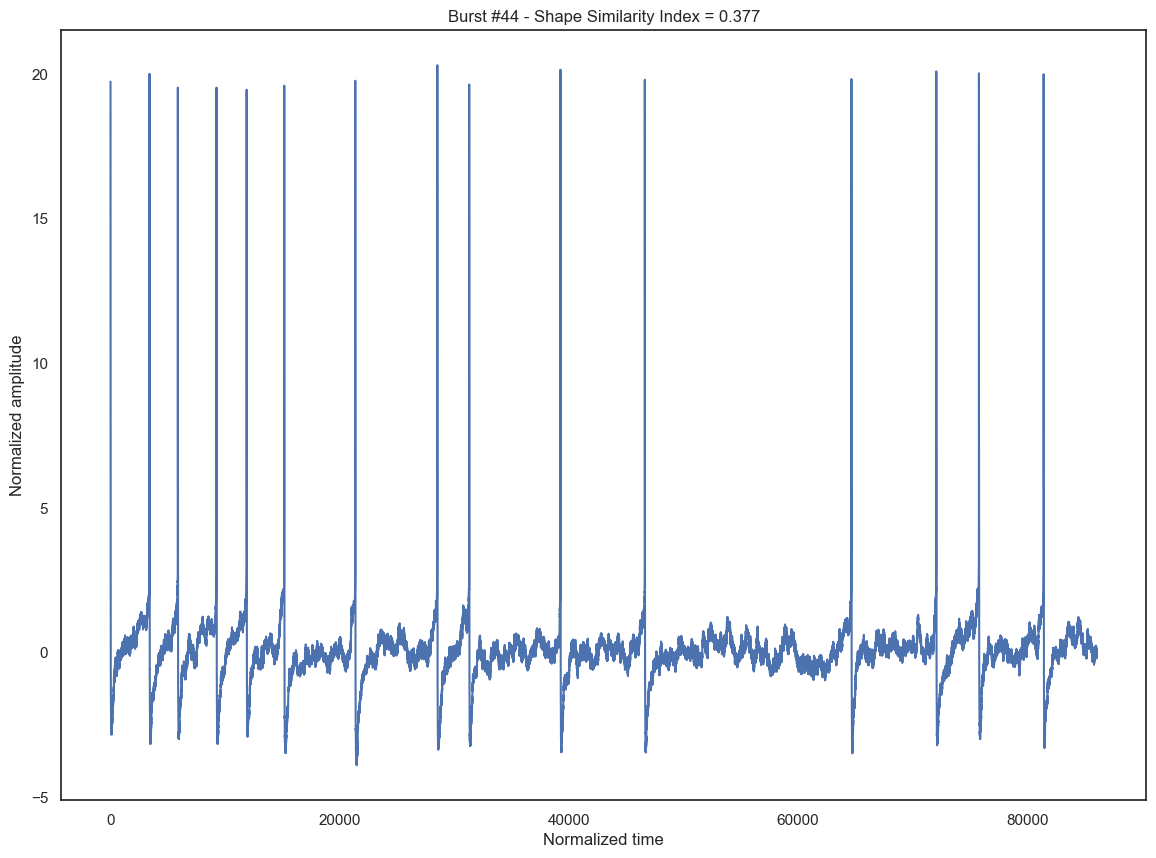

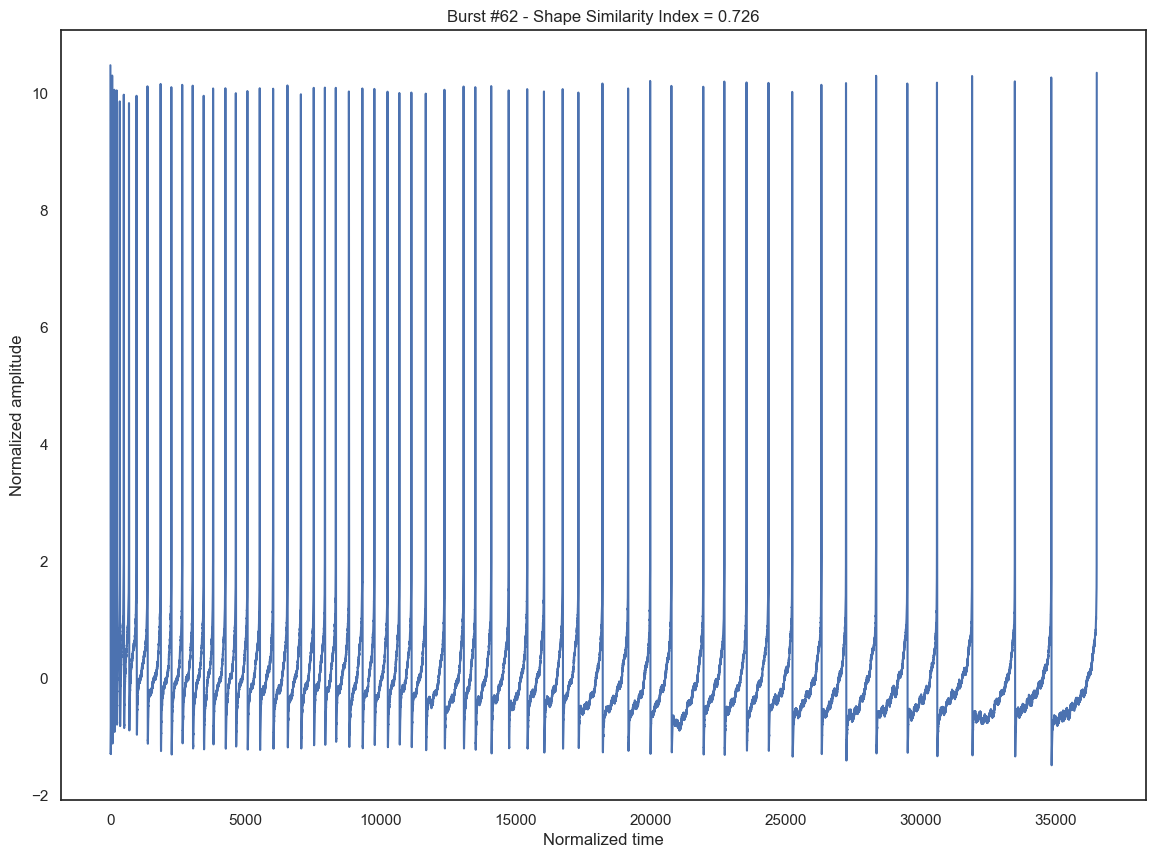

ObsoleteAttributeException: app.run_server has been replaced by app.run

In [ ]:

# Libraries

# Import all required packages for data analysis, signal processing, visualization, and the interactive dashboard.

import os                          # For handling directories and file paths
import pyabf                       # For reading Axon Binary Files (.abf) used in electrophysiology
import numpy as np                 # Numerical operations and array handling
import pandas as pd                # Data manipulation and exporting to CSV
from scipy.stats import skew, kurtosis   # Statistical metrics for signal analysis
from scipy.signal import find_peaks, hilbert  # Peak detection and Hilbert transform for envelope analysis
from numpy.linalg import lstsq     # Least-squares fitting for curve approximation
from sklearn.metrics import r2_score   # To compute R² goodness-of-fit for polynomial fitting
from sklearn.preprocessing import StandardScaler  # For normalization before dimensionality reduction
import umap                        # Uniform Manifold Approximation and Projection for dimensionality reduction

from scipy.spatial import distance             # To compute distances between centroids in UMAP space
from sklearn.neighbors import NearestNeighbors # To find neighboring points in embedding space

from fastdtw import fastdtw        # Fast Dynamic Time Warping for time-series alignment
from scipy.stats import pearsonr    # Correlation coefficient
from joblib import Parallel, delayed # Parallelization utilities for multi-core computation

import matplotlib.pyplot as plt     # Plotting and visualization
import seaborn as sns               # Statistical plotting style
sns.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})

# Libraries for interactive web-based visualization (Dash + Plotly)
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"  # Force Plotly to open figures in browser


# 1. Parameters
# Define analysis parameters and constants used throughout the script.

folder_path = "bursting"   # Directory containing .abf electrophysiological data files
threshold = -35            # Voltage threshold (mV) for spike detection
burst_threshold = 0.3      # Maximum interspike interval (s) to group spikes into a burst
fs = 10000                 # Sampling frequency (Hz)
dt = 1 / fs                # Sampling interval (s)
min_spikes_in_burst = 4    # Minimum number of spikes required to classify as a burst
n_jobs = 4                 # Number of parallel jobs for DTW computation

# Lists to store computed metrics and segment traces
all_segment_metrics = []
all_segment_traces = []

# Get all .abf files in the target folder
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]


# 2. ABF Processing Loop
# This section reads each ABF file, extracts voltage recordings,
# detects spikes and bursts, segments the data, and calculates statistical features.

for file_name in abf_files:
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)  # Load the ABF file

    # Iterate over all sweeps (recording segments) in the ABF file
    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)
        time = abf.sweepX       # Time vector (seconds)
        voltage = abf.sweepY    # Voltage trace (mV)

        # Spike detection 
        # Detect peaks above the defined threshold.
        peaks, _ = find_peaks(voltage, height=threshold)
        spike_times = peaks / fs  # Convert sample indices to time (s)

        # Burst detection 
        # Identify groups of spikes that occur close together in time.
        bursts = []
        if len(spike_times) >= min_spikes_in_burst:
            isi = np.diff(spike_times)   # Compute interspike intervals (ISIs)
            current_burst = [spike_times[0]]

            for i in range(1, len(spike_times)):
                # If the ISI is below the burst threshold, continue the same burst
                if isi[i-1] < burst_threshold:
                    current_burst.append(spike_times[i])
                else:
                    # End the burst if ISI is too large
                    # Save only if burst meets minimum spike count
                    if len(current_burst) >= min_spikes_in_burst:
                        bursts.append((current_burst[0], current_burst[-1]))
                    current_burst = [spike_times[i]]

            # Check the last burst segment
            if len(current_burst) >= min_spikes_in_burst:
                bursts.append((current_burst[0], current_burst[-1]))

        # Define signal segments
        # Create labeled segments: "Burst" or "Non-burst" intervals
        segments = []
        for start, end in bursts:
            segments.append((start, end, "Burst"))

        # Add non-burst intervals between and around bursts
        if bursts:
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            for i in range(len(bursts) - 1):
                segments.append((bursts[i][1], bursts[i + 1][0], "Non-burst"))
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            segments.append((time[0], time[-1], "Non-burst"))

        # Burst classification
        # Determine whether each burst looks like a "Square Wave" or "Parabolic"
        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):
            if seg_type == "Burst":
                seg_mask = (time >= seg_start) & (time <= seg_end)
                seg_voltage = voltage[seg_mask]

                # Compute mean voltage in inter-burst regions before and after
                prev_mean = np.nan
                next_mean = np.nan
                if i > 0:
                    prev_end = segments[i - 1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments) - 1:
                    next_start = segments[i + 1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])
                inter_mean = np.nanmean([prev_mean, next_mean])

                # Minimum voltage within the burst
                burst_min = np.min(seg_voltage)

                # Fit a parabola to evaluate curvature (for parabolic shape detection)
                t_fit = np.linspace(-0.5, 0.5, len(seg_voltage))
                X = np.vstack([t_fit**2, t_fit, np.ones_like(t_fit)]).T
                coef, *_ = lstsq(X, seg_voltage, rcond=None)
                y_hat = X @ coef
                r2_parabola = r2_score(seg_voltage, y_hat)

                # Hilbert transform for envelope symmetry measurement
                analytic_signal = hilbert(seg_voltage)
                envelope = np.abs(analytic_signal)
                half = len(envelope) // 2
                symmetry = (
                    np.corrcoef(envelope[:half], envelope[-half:][::-1])[0, 1]
                    if half >= 2 else np.nan
                )

                # Count number of peaks in burst and estimate spike rate
                seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
                spike_rate = len(seg_peaks) / (seg_end - seg_start)

                # Classify burst type based on voltage morphology
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                burst_type = "Non-burst"

            burst_types.append(burst_type)

        # Segment metrics
        # Compute quantitative features for each segment for later analysis.
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]

            duration = seg_end - seg_start
            burst_type = burst_types[j]

            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)
            mean_isi = np.mean(np.diff(seg_peaks / fs)) if num_peaks >= 2 else 0

            # Compute basic statistical measures of the voltage trace
            if len(seg_voltage) < 2:
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
            else:
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                area_val = np.trapezoid(seg_voltage, dx=dt)

            # Compute statistics for the first derivative (dV/dt)
            if len(seg_voltage) < 2:
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                deriv = np.diff(seg_voltage) / dt
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)

            # Store computed metrics and raw voltage trace
            all_segment_metrics.append([
                file_name, sweep, seg_type, burst_type, duration,
                num_peaks, mean_isi,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])
            all_segment_traces.append(seg_voltage.tolist())


# 3. Save CSV and traces
# Convert collected metrics into a DataFrame and export to CSV for external analysis.
df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration",
    "Num_Peaks", "Mean_ISI",
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv", "Skewness_Deriv", "Kurt_Deriv"
])
df_segments.to_csv("segment_voltage_metrics_with_ISI_and_peaks.csv", index=False)

# Add the voltage trace array to the DataFrame (used later for visualization)
df_segments["signal_array"] = all_segment_traces


# 4. UMAP dimensionality reduction
# Reduce the high-dimensional feature space to 2D for visualization and clustering.
header = list(df_segments)[4:-1]  # Select feature columns (exclude metadata and traces)
X = np.array(df_segments[header])
y = np.array(df_segments.Burst_Type)

# Standardize features to zero mean and unit variance before UMAP
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP to extract a 2D embedding
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Create DataFrame for UMAP visualization
df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_umap["Burst_Type"] = y
df_umap["id"] = np.arange(len(df_umap))
df_umap["Index"] = df_segments.index


# 5. Detect conflicts between burst types
# Identify regions in UMAP space where bursts of different types overlap.
centroids = df_umap.groupby("Burst_Type")[["UMAP1", "UMAP2"]].mean()
dist_matrix = distance.cdist(centroids.values, centroids.values)
threshold_overlap = np.percentile(dist_matrix[dist_matrix > 0], 10)

# Compute nearest neighbors in UMAP space
X_umap = df_umap[["UMAP1", "UMAP2"]].values
labels = df_umap["Burst_Type"].values
nbrs = NearestNeighbors(n_neighbors=8).fit(X_umap)
distances, indices = nbrs.kneighbors(X_umap)

# Identify points that have neighbors of different types (potential conflicts)
conflict_indices = []
for i, neighbors in enumerate(indices):
    own_type = labels[i]
    neighbor_types = labels[neighbors]
    if np.any(neighbor_types != own_type):
        conflict_indices.append(df_umap.iloc[i]["Index"])

# Extract conflicting segments
df_conflict = df_segments.iloc[conflict_indices].reset_index(drop=True)
df_conflict["UMAP1"] = df_umap.iloc[conflict_indices]["UMAP1"].values
df_conflict["UMAP2"] = df_umap.iloc[conflict_indices]["UMAP2"].values


# 6. Shape analysis using DTW and correlation
# Evaluate waveform similarity within conflicting regions using Dynamic Time Warping

def normalize(x):
    # Normalize a signal to zero mean and unit variance
    x = np.array(x)
    return (x - np.mean(x)) / (np.std(x) + 1e-8)

def dtw_correlation(sig1, sig2):
    # Align two signals with DTW and compute correlation of the aligned traces
    s1, s2 = normalize(sig1), normalize(sig2)
    dist, path = fastdtw(s1, s2)
    aligned1 = np.array([s1[i] for i, j in path])
    aligned2 = np.array([s2[j] for i, j in path])
    corr = pearsonr(aligned1, aligned2)[0]
    return dist, corr

# Build neighborhood structure for conflicting bursts
embedding_conflict = df_conflict[["UMAP1", "UMAP2"]].values
nbrs_conflict = NearestNeighbors(n_neighbors=6).fit(embedding_conflict)
_, indices_conflict = nbrs_conflict.kneighbors(embedding_conflict)

def compute_similarity(i):
    #Compute average DTW distance and post-alignment correlation for each burst.
    sig_i = df_conflict.iloc[i]["signal_array"]
    if not isinstance(sig_i, (list, np.ndarray)):
        return np.nan, np.nan
    local_dtw, local_corr = [], []
    for j in indices_conflict[i, 1:]:
        sig_j = df_conflict.iloc[j]["signal_array"]
        if not isinstance(sig_j, (list, np.ndarray)):
            continue
        dist, corr = dtw_correlation(sig_i, sig_j)
        local_dtw.append(dist)
        local_corr.append(corr)
    return np.nanmean(local_dtw), np.nanmean(local_corr)

# Parallel computation for efficiency
results = Parallel(n_jobs=n_jobs)(delayed(compute_similarity)(i) for i in range(len(df_conflict)))
dtw_dists, corr_means = zip(*results)

# Add computed shape similarity metrics to the DataFrame
df_conflict["Mean_DTW_Dist"] = dtw_dists
df_conflict["Mean_Corr_PostDTW"] = corr_means
df_conflict["Shape_Similarity_Index"] = (
    (1 - df_conflict["Mean_DTW_Dist"] / np.nanmax(df_conflict["Mean_DTW_Dist"])) * 0.5 +
    (df_conflict["Mean_Corr_PostDTW"] / np.nanmax(df_conflict["Mean_Corr_PostDTW"])) * 0.5
)

# Visualization of shape coherence
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_conflict,
    x="UMAP1", y="UMAP2",
    hue="Shape_Similarity_Index",
    palette="viridis", s=50
)
plt.title("Shape coherence in conflicting regions")
plt.legend(title="Similarity", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Identify bursts with low shape coherence
threshold_low = df_conflict["Shape_Similarity_Index"].quantile(0.1)
low_similarity_bursts = df_conflict[df_conflict["Shape_Similarity_Index"] < threshold_low]
print(f"Low-similarity conflicting bursts (<p10): {len(low_similarity_bursts)}")

# Plot a few examples of low-similarity bursts
for idx in low_similarity_bursts.index[:5]:
    sig = df_conflict.loc[idx, "signal_array"]
    plt.figure()
    plt.plot(normalize(sig))
    plt.title(f"Burst #{idx} - Shape Similarity Index = {df_conflict.loc[idx,'Shape_Similarity_Index']:.3f}")
    plt.xlabel("Normalized time")
    plt.ylabel("Normalized amplitude")
    plt.show()


# 7. Interactive Dashboard (Dash)
# Build a web-based interface to explore UMAP clusters and inspect voltage traces.

app = Dash(__name__)
app.layout = html.Div([
    html.H2("Interactive Explorer: UMAP + Bursts"),
    html.P("Click on a point to visualize its corresponding burst trace."),

    # 2D UMAP plot with burst type coloring
    dcc.Graph(
        id="umap",
        figure=px.scatter(
            df_umap,
            x="UMAP1",
            y="UMAP2",
            color="Burst_Type",
            hover_data=["id", "Burst_Type"],
            custom_data=["id"],
            title="UMAP of voltage segments"
        )
    ),

    # Placeholder for time-series trace
    dcc.Graph(id="timeseries")
])

# Interactivity: clicking on UMAP points shows the corresponding voltage trace 
@app.callback(
    Output("timeseries", "figure"),
    Input("umap", "clickData")
)

def display_timeseries(clickData):

    # If no point was clicked, return a placeholder plot with instructions
    if clickData is None:
        fig = go.Figure()
        fig.update_layout(
            title="Click a point in the UMAP plot to view its burst waveform",
            xaxis_title="Time (s)",
            yaxis_title="Voltage (mV)"
        )
        return fig

    # Extract the customdata field that contains the 'id' we stored in df_umap
    # Plotly stores the clicked point info under clickData["points"][0]
    burst_id = clickData["points"][0]["customdata"][0]

    # Defensive check: ensure index is valid for all_segment_traces
    try:
        trace = all_segment_traces[int(burst_id)]
    except Exception:
        # If the id is invalid for any reason, return a message figure
        fig = go.Figure()
        fig.update_layout(
            title=f"Could not retrieve trace for segment id {burst_id}",
            xaxis_title="Time (s)",
            yaxis_title="Voltage (mV)"
        )
        return fig

    # Convert the saved trace into a numpy array and build a time vector
    y = np.array(trace)
    # Time axis: length(y)/fs gives total seconds; linspace includes end point so shape matches y
    t = np.linspace(0, len(y) / fs, len(y), endpoint=False)

    # Create an interactive line plot of the voltage trace
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=t,
            y=y,
            mode="lines",
            name=f"Segment {burst_id}"
        )
    )

    # Annotate plot with basic layout settings
    fig.update_layout(
        title=f"Time series of segment {burst_id} (Sweep trace)",
        xaxis_title="Time (s)",
        yaxis_title="Voltage (mV)",
        hovermode="x unified"
    )

    return fig



# Run the Dash app
if __name__ == "__main__":
    # Using debug=True during development is convenient (auto-reload, detailed errors).
    # In production or stable environments, set debug=False.
    app.run(debug=True)
